# Ch. 7 Moving Beyond Linearity

In [39]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.gam.api import GLMGam, BSplines
from patsy import dmatrix

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Cannot call scipy interpolate from "conda" directory.
#from scipy.interpolate import PiecewisePolynomial

import os.path
from src import ch7_utils

%matplotlib inline

## 2. Smoothly Fit a Set of Points

 #### Smoothing Splines Overview and 
 - The **second derivative** of a function is a measure of its **roughness**.
 - If the g(t) is **very wiggly** then its **first derivative varies signifinicantly** and its **second derivative** is **large** in absolute terms.
 - If g(t) is **smooth** then its **first derivative** will be close to **constant** and its **second derivative** will be **small** in absolute terms.
 
##### Lambda - Nonnegative Tuning Parameter
 - Controls the bias-variance tradeoff of a smoothing spline.
 - When **lambda = 0**, the penalty term has **no effect**. Consequently, g(t) will be very jumpy and replicate the training observations.
 - When **lambda nears infinity**, g(t) will be perfectly smooth. It will be a straight line that passess as closesly as possible to the training points. In this case, g(t) will be the linear lease squares line since the loss function amounts to minimiziing the residual sum of squares (RSS).
 

**QUESTIONS**

 (a) Slightly smoothed<br>
 (b) More smooth than the line in 2(a).<br>
 (c) More smooth than the line in question 2(b).<br>
 (d) Line becomes more linear.<br>
 (e) Then penalty term has no effect. The line mirrors the training observations.<br>

## 5. Consider Two Smoothed Curves

**QUESTIONS**

 (a) Either the same or g(t)^4 <br>
 (b) Either the same or g(t)^3 <br>
 (c) g(t)^4 will have a smaller training RSS. g(t)^3 will have a smaller test RSS. <br>

## 6a. Polynomial regression to predict wage using age

Import and Process age and wage data.

In [2]:
url_path = os.path.abspath('..')
wage = pd.read_csv(url_path + '/data/wage.csv', index_col=0)

age_arr = wage['age'].values.reshape(-1, 1)
wage_arr = wage['wage']

X_train, X_test, y_train, y_test = train_test_split(age_arr, wage_arr, test_size=0.2, random_state=3)

In [3]:
wage.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


Perform Kfold Cross-Validation

In [4]:
#cv = Kfold(n_splits=10, shuffle=True, random_state=3)
degrees = [0,1, 2, 3, 4, 5, 6, 7, 8]
mse_arr = []

for degree in degrees:
    age_poly = PolynomialFeatures(degree=degree).fit_transform(age_arr)
    linear_model = LinearRegression()
    
    c_val = cross_val_score(linear_model, X=age_poly, y=wage_arr, cv=10, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    mse_arr.append(-c_val)


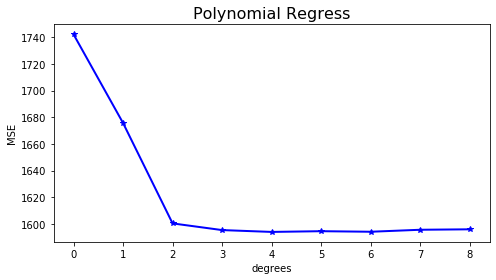

In [5]:
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(degrees, mse_arr, c='b', linewidth=2, marker='*')
ax.set_xlabel('degrees')
ax.set_ylabel('MSE')
ax.set_title('Polynomial Regress', fontsize=16)
fig.tight_layout();

Degree 4 has the smallest training MSE.

##### Use statsmodel package to perform hypothesis testing using ANOVA.

Generalized least squares (GLS) is a technique for estimating the unknown parameters in a linear regression model when there is a certain degree of correlation between the residuals in a regression model.  In these cases, ordinary least squares and weighted least squares can be statistically inefficient, or even give misleading inferences. The GLS estimator is unbiased, consistent, efficient, and asymptotically normal. 

A **more efficient** estimator requires less observation than a **less efficient** estimator.

In [37]:
models = []

for i in range(0, 9):
    poly = PolynomialFeatures(degree=i)
    age_poly = poly.fit_transform(age_arr)
    # Generalized least squares
    model = sm.GLS(wage_arr, age_poly).fit()
    models.append(model)

In [38]:
sm.stats.anova_lm(models[0], models[1], models[2], models[3], models[4], models[5], models[6], models[7], models[8], typ=1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2999.0,5.222086e+06,0.0,NaN,NaN,NaN
1,2998.0,5.022216e+06,1.0,199869.664970,125.565233,1.404041e-28
2,2997.0,4.793430e+06,1.0,228786.010128,143.731509,2.211791e-32
3,2996.0,4.777674e+06,1.0,15755.693664,9.898287,1.670556e-03
4,2995.0,4.771604e+06,1.0,6070.152124,3.813485,5.093457e-02
5,2994.0,4.770322e+06,1.0,1282.563017,0.805752,3.694514e-01
6,2993.0,4.766389e+06,1.0,3932.257643,2.470384,1.161153e-01
7,2993.0,4.764599e+06,-0.0,1790.520845,-inf,NaN
8,2993.0,4.764136e+06,-0.0,462.420372,-inf,NaN


The lower the values of F, the lower the significance of the coefficient. Degrees higher than 4 don't improve the polynomial regression model significantly. This results is in agreement with cross validation results.

In [40]:
optimal_degree = 4

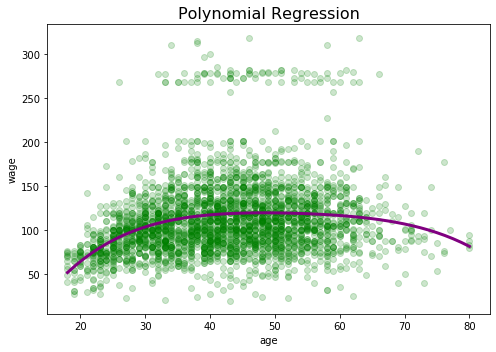

In [53]:
poly_reg_model = Pipeline([('poly', PolynomialFeatures(degree = optimal_degree)), ('linear', LinearRegression())])
poly_reg_model.fit(age_arr, wage_arr)

X_lin = np.linspace(18, 80).reshape(-1,1)
y_lin = poly_reg_model.predict(X_lin)

fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(age_arr, wage_arr, c='g', alpha=0.2)
ax.plot(X_lin, y_lin, c='purple', linewidth=3)

ax.set_title('Polynomial Regression', fontsize=16)
ax.set_xlabel('age')
ax.set_ylabel('wage')

fig.tight_layout();

C:\Users\morga\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


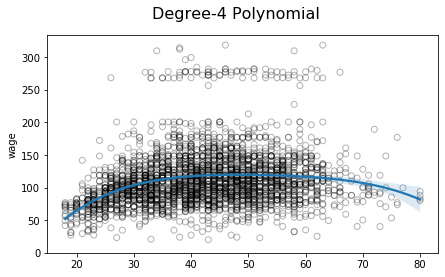

In [54]:
# USED SEABORN FOR REGRESSION
fig, ax = plt.subplots(figsize=(7,4))
fig.suptitle('Degree-4 Polynomial', fontsize=16)

# scatter plot with polynomial regression line
ax.scatter(age_arr, wage_arr, facecolor='None', edgecolor='k', alpha=0.3)
# if order > 1, use polynomial fit.
sns.regplot(age_arr, wage_arr, order=optimal_degree, truncate=True, scatter=False, ax=ax)
ax.set_ylim(ymin=0);


## 6b. Step function to predict wage using age

### Functions

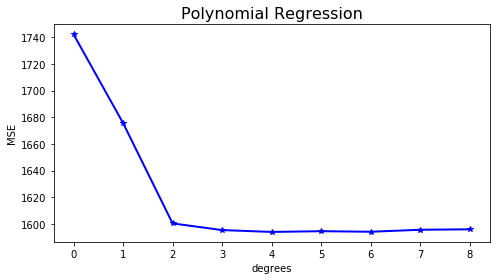

In [7]:
ch7_utils.calc_and_plot_mse_for_polynomial_degrees(age_arr, wage_arr, degrees, cv=10)

## 7. Apply Polynomial regression to predict an individual's wage using other features from the "wage" dataset.

Skipped because must learn how to perform GAM in python.

## 8. Perform non-linear modeling to the Auto dataset. Is there evidence for non-linear relationships? Create informative plots to justify your answer.

In [8]:
url_path = os.path.abspath('..')
auto = pd.read_csv(url_path + '/data/auto.csv')

auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [9]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    397 non-null    object 
 4   weight        397 non-null    int64  
 5   acceleration  397 non-null    float64
 6   year          397 non-null    int64  
 7   origin        397 non-null    int64  
 8   name          397 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.0+ KB


In [10]:
X = auto.drop(['mpg', 'name', 'origin', 'cylinders'], axis=1)
y = auto['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

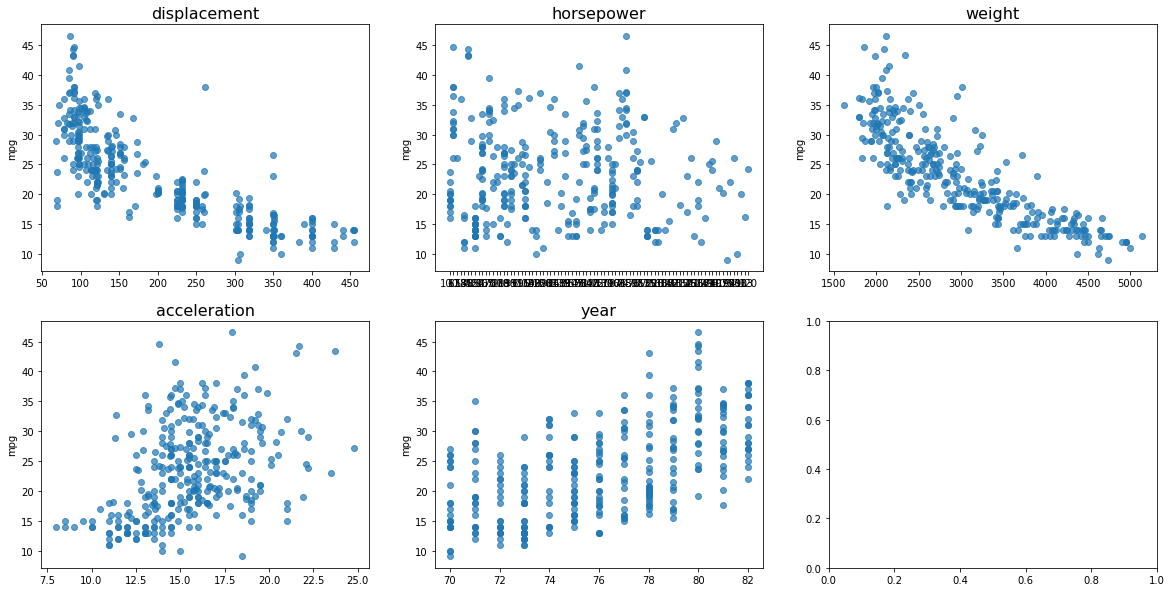

In [11]:
indices = list(range(0, 5))
features = ['displacement', 'horsepower', 'weight', 'acceleration', 'year']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()
for idx, feat in enumerate(features):
    axes[idx].scatter(x=X_train[feat], y=y_train, alpha=0.7)
    axes[idx].set_title(feat, fontsize=16)
    axes[idx].set_ylabel('mpg')

**Displacement** and **Weight** seem to have a non-linear relationship.

#### Displacement and MPG

In [12]:
X_train_displacement = X_train['displacement'].values.reshape(-1,1)
X_test_displacement = X_test['displacement'].values.reshape(-1, 1)

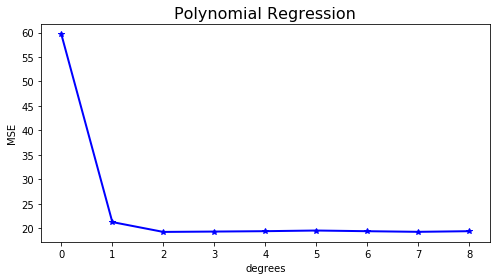

In [13]:
degrees = [0,1, 2, 3, 4, 5, 6, 7, 8]

ch7_utils.calc_and_plot_mse_for_polynomial_degrees(X_train_displacement, y_train, degrees, cv=10)

A polynomial with 2 degrees minimizes MSE.

#### Linear Regression

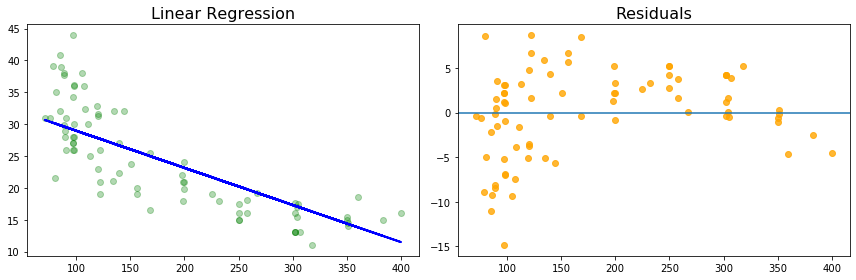

In [14]:
ch7_utils.fit_lin_reg_to_create_plots_and_residuals(X_train_displacement, y_train, X_test_displacement, y_test)

#### Polynomial Regression

C:\Users\morga\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


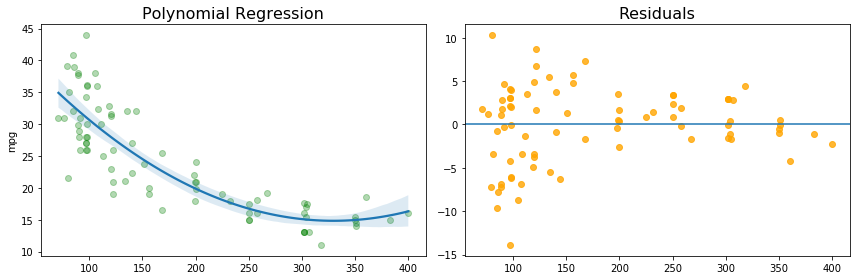

In [15]:
ch7_utils.create_fit_polynomial_reg_and_graph_predictions_and_residuals(X_train_displacement, y_train, X_test_displacement, y_test, 2)

#### MSE - Linear and Polynomial

In [21]:
y_pred_linear = ch7_utils.linear_reg_predictions(X_train_displacement, y_train, X_test_displacement)

X_train_displacement_poly, X_test_displacement_poly = ch7_utils.transform_variables_to_polynomial(X_train_displacement, X_test_displacement, 2)
y_pred_poly = ch7_utils.linear_reg_predictions(X_train_displacement_poly, y_train, X_test_displacement_poly)

mse_linear = round(mean_squared_error(y_test, y_pred_linear), 3)
mse_poly = round(mean_squared_error(y_test, y_pred_poly), 3)

print("Linear Regression MSE: ", mse_linear)
print("Polynomial Regression MSE: ", mse_poly)

Linear Regression MSE:  23.396
Polynomial Regression MSE:  19.069


### Weight and MPG

In [22]:
X_train_weight = X_train['weight'].values.reshape(-1,1)
X_test_weight = X_test['weight'].values.reshape(-1,1)

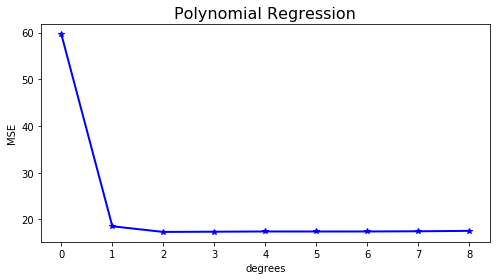

In [23]:
degrees = [0,1, 2, 3, 4, 5, 6, 7, 8]

ch7_utils.calc_and_plot_mse_for_polynomial_degrees(X_train_weight, y_train, degrees, cv=10)

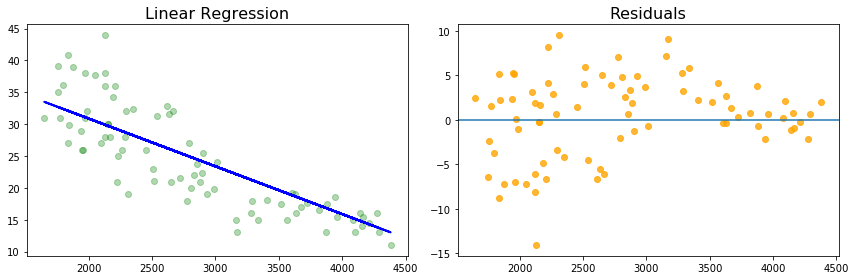

In [24]:
ch7_utils.fit_lin_reg_to_create_plots_and_residuals(X_train_weight, y_train, X_test_weight, y_test)

C:\Users\morga\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


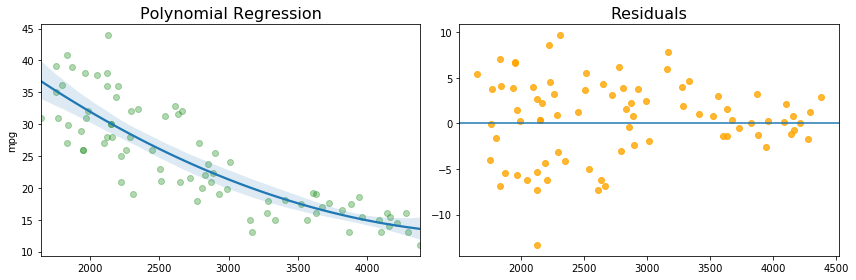

In [25]:
ch7_utils.create_fit_polynomial_reg_and_graph_predictions_and_residuals(X_train_weight, y_train, X_test_weight, y_test, 2)

#### MSE - Linear and Polynomial - Weight

In [27]:
y_pred_linear = ch7_utils.linear_reg_predictions(X_train_weight, y_train, X_test_weight)

X_train_weight_poly, X_test_weight_poly = ch7_utils.transform_variables_to_polynomial(X_train_weight, X_test_weight, 2)
y_pred_poly = ch7_utils.linear_reg_predictions(X_train_weight_poly, y_train, X_test_weight_poly)

mse_linear = round(mean_squared_error(y_test, y_pred_linear), 3)
mse_poly = round(mean_squared_error(y_test, y_pred_poly), 3)

print("Linear Regression MSE: ", mse_linear)
print("Polynomial Regression MSE: ", mse_poly)

Linear Regression MSE:  20.435
Polynomial Regression MSE:  18.537


## 9. Non-linear Models using Boston data 

 - dis - weighted mean of the distance to 5 Boston employment centers - is the predictor
 - nox - nitrogen oxides concentration in part per 10 million - is the response

In [28]:
url_path = os.path.abspath('..')
boston = pd.read_csv(url_path + '/data/Boston.csv')

boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


#### (a) Fit a cubic polynomial regression to predic "nox" using "dis".

C:\Users\morga\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


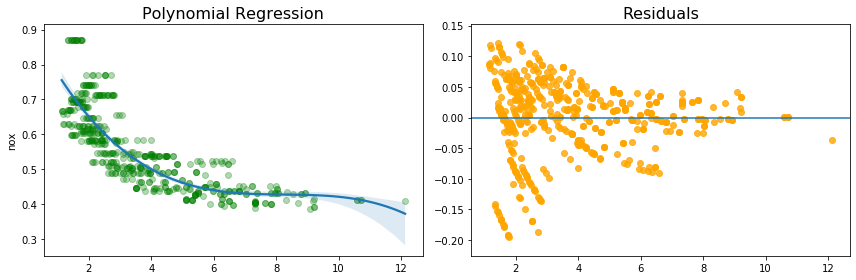

In [29]:
X = boston['dis'].values.reshape(-1, 1)
y = boston['nox']

ch7_utils.create_fit_polynomial_reg_and_graph_predictions_and_residuals(X, y, X, y, 3)

#### (b) + (c) Perform cross-validation to select the optimal number of degrees. 

ISLR asks for RSS, but I use MSE.

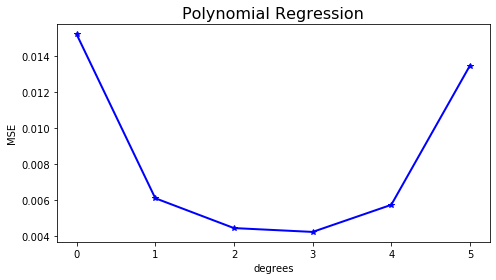

In [30]:
degrees = np.arange(0, 6)
cross_val = 10
ch7_utils.calc_and_plot_mse_for_polynomial_degrees(X, y, degrees, cross_val)

## 10. Use stepwise selection to identify a satistfactory model that use a subset of the predictors

In [19]:
url_path = os.path.abspath('..')
college = pd.read_csv(url_path + '/data/College.csv', index_col=0)

college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [37]:
college = pd.get_dummies(college)

college.head()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private_No,Private_Yes
Abilene Christian University,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,0,1
Adelphi University,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,0,1
Adrian College,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,0,1
Agnes Scott College,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,0,1
Alaska Pacific University,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,0,1


In [46]:
X = college.drop('Outstate', axis=1)
y = college['Outstate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

#### Forward Stepwise Selection

C:\Users\morga\anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\morga\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


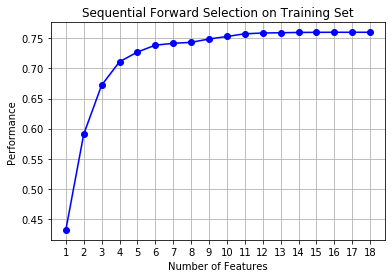

In [48]:
lin_reg = LinearRegression()

sfs = SFS(lin_reg,
          k_features = X.shape[1],
          forward = True,
          floating = False,
          scoring = 'r2', # R-squared
          cv = 0)

sfs = sfs.fit(X_train.values, y_train) # as_matrix() is required for SFS

fig = plot_sfs(sfs.get_metric_dict())

plt.title('Sequential Forward Selection on Training Set')
plt.grid()
plt.show();

In [49]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

C:\Users\morga\anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\morga\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(14,)",[0.4317455736782212],0.431746,"(14,)",NaN,0,NaN
2,"(14, 16)",[0.5907572029855366],0.590757,"(14, 16)",NaN,0,NaN
3,"(7, 14, 16)",[0.6721087270474944],0.672109,"(7, 14, 16)",NaN,0,NaN
4,"(7, 13, 14, 16)",[0.7111111026791879],0.711111,"(7, 13, 14, 16)",NaN,0,NaN
5,"(7, 13, 14, 15, 16)",[0.7272377213995019],0.727238,"(7, 13, 14, 15, 16)",NaN,0,NaN
6,"(7, 11, 13, 14, 15, 16)",[0.7386976804417855],0.738698,"(7, 11, 13, 14, 15, 16)",NaN,0,NaN
7,"(7, 9, 11, 13, 14, 15, 16)",[0.7416645021321613],0.741665,"(7, 9, 11, 13, 14, 15, 16)",NaN,0,NaN
8,"(1, 7, 9, 11, 13, 14, 15, 16)",[0.7434044009030967],0.743404,"(1, 7, 9, 11, 13, 14, 15, 16)",NaN,0,NaN
9,"(1, 5, 7, 9, 11, 13, 14, 15, 16)",[0.7488191062919962],0.748819,"(1, 5, 7, 9, 11, 13, 14, 15, 16)",NaN,0,NaN
10,"(0, 1, 5, 7, 9, 11, 13, 14, 15, 16)",[0.7530627676282208],0.753063,"(0, 1, 5, 7, 9, 11, 13, 14, 15, 16)",NaN,0,NaN


In [56]:
selected_feature_idx = [14, 16, 7, 13, 15, 11]

print('Selected Features - Order of Importance\n')
for idx in selected_feature_idx:
    print('{}. {}'.format(idx, X.columns[idx]))

Selected Features - Order of Importance

14. Expend
16. Private_No
7. Room.Board
13. perc.alumni
15. Grad.Rate
11. Terminal
